# Homework 1 - data validation & cleaning (deadline 18. 11. 2019)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best as you can. ;)

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  2. Check consistency (i.e. that same things are represented in the same way) of at least three features where you expect problems (include "Object Name" feature).
  3. Select some features where you expect integrity problems (describe your choice) and check integrity of those features. By integrity we mean correct logical relations between features (e.g. female names for females only).
  4. Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.
  5. Find some outliers (describe your method).
  6. Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.

**If you do all this properly, you will obtain 16 points**

To earn **two points** for extra activity you can do some of these:
  * Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.
  * Focus on the extraction of physical dimensions of each item (width, depth and height in centimeters) from the "Dimensions" feature.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(100)

In [2]:
path = "MetObjects.csv"
df = pd.read_csv(path, encoding='utf-8', low_memory=False)
raw = df.copy()
df = df.drop(columns=['Repository'])

In [3]:
df.nunique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470172 entries, 0 to 470171
Data columns (total 43 columns):
Object Number              470172 non-null object
Is Highlight               470172 non-null bool
Is Public Domain           470172 non-null bool
Object ID                  470172 non-null int64
Department                 470172 non-null object
Object Name                468389 non-null object
Title                      440004 non-null object
Culture                    205809 non-null object
Period                     88593 non-null object
Dynasty                    23136 non-null object
Reign                      11157 non-null object
Portfolio                  22989 non-null object
Artist Role                266220 non-null object
Artist Prefix              88771 non-null object
Artist Display Name        268315 non-null object
Artist Display Bio         229219 non-null object
Artist Suffix              11955 non-null object
Artist Alpha Sort          268280 non-null object


# Consistency Check
**TASK: Check consistency (i.e. that same things are represented in the same way) of at least three features where you expect problems (include "Object Name" feature).**

Below i will describe and check suspicious features 
## 'Object Name' feature
Represents a feature, where name for each object is stored.
- First, let's see how many null values and unique values this feature contain:

In [50]:
o_name = df['Object Name']
print("n. of nulls:", o_name.isnull().sum(), '; {:.4}'.format((o_name.isnull().sum()/len(o_name))*100) + "% of null values")
print("n. unique values:", o_name.nunique())
pd.Series(o_name.unique()).to_csv('object_name.csv')

n. of nulls: 1783 ; 0.3792% of null values
n. unique values: 27902


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


- *all the object names are in object_name.csv file - to see all of them*

**After I took a close look on records in this column I saw some consistency problems, e.g.:**

- italics are represented in a weird way

`Armor (<i>Gusoku</i>)`

- each record should be lowercase or consistent

`Blade and mounting for a short sword (Waskizashi)`

`Blade and mounting for a short sword (wakizashi)`

- quotes should not be present (I dont see any reason to keep it)

`"Autophone" Organette`

- random comas appearing in the middle or in the beginning

`Arm, forearm`

`, uninscribed scarab`

Why there are entries with several items at once - separated by semicolon?

`Photogravures; Photograms; Rayographs; Portfolios`

- unwanted dashes - describing the same thing, two different ways:

`Amulet, ba bird`

`Amulet, ba-bird`

- number of items per record

`12 textile samples`

`9-13 shell beads between 2 carnelian beads`

- same things, diff. number of items
`Bead ornaments, circular, 10`

`Bead ornaments, circular, 45`

- sometimes messing with brackets

`Beads (15)`

`Beads (16)`


- question marks - I cannot classify or could be two things?

`Akhenaten or Nefertiti big toe of prostrate foot (?)`


- Adjectives should be in a different column, or we should have separate column for each word.

`Broad Collar, Hapiankhtifi`

`Broad Collar, Nefer amulets`

`Cone, circular stamp, Merymose, king's son, Kush`

`Cone, circular stamp, Sennetjer, scribe`

because when querying this column, I may be looking for all cones, and I dont care about the type of the cone. I would rather keep the type in a separate column.

### Overall,

- I would try to remove all dashes, if there is no reason to keep it. 
- `<i><\i>` definitely out
- lowercase each record
- put number of items into a separate column
- separate column for objects, where I am not sure what it is
- make adjectives - types - as a separate column. Even better - column for each word in the entry, and occurence-of-the-word in the entry as value. Memory is crying, but we are having machine-readable form
- ...

*For sure, there are more problems. I  was not asked to **repair** this column, so I will leave here just this analysis*

In [51]:
x = o_name[o_name.fillna('').str.contains("[D|d]rawer")]
unique, counts = np.unique(x, return_counts=True)
np.asarray((unique, counts)).T

array([['Cabinet of drawers', 1],
       ['Cabinet with drawers', 2],
       ['Case with tray and drawers', 1],
       ['Chest of drawers', 33],
       ['Chest with drawer', 6],
       ['Chest with drawers', 4],
       ['Chest-with-drawer', 2],
       ['Chest-with-drawers', 1],
       ['Drawer fronts', 1],
       ['Drawer handle and plate', 1],
       ['Drawer pull', 24],
       ['Drawer pulls', 7],
       ['Drawers', 52],
       ['Handle of drawer pull', 1],
       ['High Chest of drawers', 1],
       ['High chest of drawers', 9],
       ['Rack of drawers', 1]], dtype=object)

Above we can see records and their count, where word 'drawer' occurs. Inconsistency is nicely visible.

## 'Dynasty' feature

In [52]:
dynasty = pd.Series(df["Dynasty"].fillna('').unique())
pd.Series(np.sort(dynasty[dynasty.str.contains("12")]))

0                                                12
1                                  Dynasty 11 or 12
2                               Dynasty 11, late-12
3                        Dynasty 11, late–12, early
4                                     Dynasty 11-12
5                                     Dynasty 11–12
6                                 Dynasty 11–mid 12
7                                        Dynasty 12
8                                    Dynasty 12 (?)
9                                 Dynasty 12 mid-13
10                              Dynasty 12 probably
11                   Dynasty 12 to early Dynasty 13
12                            Dynasty 12, beginning
13                                Dynasty 12, early
14                          Dynasty 12, early - mid
15                            Dynasty 12, early-mid
16                Dynasty 12, early–to Senwosret II
17                                 Dynasty 12, late
18                    Dynasty 12, late  - 13, early
19          

A lot of mess. And this is happening only on records, which contain '12'. Examples of possible problems:
- dashes not needed and if so, it should be consistent

`early to mid Dynasty 12`
`early to mid-Dynasty 12`

- when regarding to the specific time of the dynasty, rather use simple early/late

`Dynasty 12, early–to Senwosret II`
`mid to end Dynasty 12`

And of course, don't use word 'Dynasty', if it is the name of the column.

- to provide clean data of dynasties, I would use regexes to remove 'Dynasty' word, and try to make an interval - possibly in two columns. One can keep late and early, connected with the beginning/end of the interval. 

## 'Country' feature

In [56]:
pd.options.display.max_rows = 100
country = pd.Series(df["Country"].fillna('').unique())
country.sort_values()
country.to_csv('country.csv')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [55]:
country[country.str.contains("\?|[P|p]robably|[P|p]ossibly")].count()

195

- In a lot of records we don't know, if the country of origin is exactly the one described. First of all I would make a new column - certanity, for those '?' values.
- E.g. this

`Egypt (or Italy or Turkey)`

should be represented with '|' as ususal

- 'US' should be represented as 'USA' or vice versa


In [57]:
country[country.str.contains("[s|S]lovakia|[C|z]ech|[B|b]ohemia")]

18                  Czech Republic
36          Czech Republic|England
42          Germany|Czech Republic
494                        Bohemia
709                       Slovakia
710    Germany, France, or Bohemia
734       Czech Republic (Bohemia)
784     Czechoslovakia or Germany?
870          Bohemia|Germany|Italy
871              Bohemia (Hungary)
884     Czech Republic or Slovakia
dtype: object

`Bohemia (Hungary)` ? -> And I thought Slovaks were Hungarian ;) American historics probably think the opposite.

# Integrity Problems

**TASK: Select some features where you expect integrity problems (describe your choice) and check integrity of those features. By integrity we mean correct logical relations between features (e.g. female names for females only).**

## 'Classification' and 'Object Name'

Let's take a look on 'Classification' and 'Object Name' features. Classification may mean anything from substance the object is made of, to categorization of the object.

I expect integrity problem, not quite recognizable by machine, since this "Classification" was made by humans. I looked at each groupped entry, to find the most "weird" classifications.

Here is a list of various classification for object named "coin":

In [58]:
coins = df[df['Object Name'].fillna('').str.contains("[C|c]oin")]
coins[['Classification','Object Name', 'Object Number']].groupby(['Classification','Object Name']).count()
# coins['Object Name', 'Classification'].groupby['Classification'].count()
# grouped = df[['Classification', 'Object Name']].groupby(['Object Name', 'Classification' ]).count()
# grouped.head(100)

Object Number
Classification                 Object Name                                                      
Coins                          Coin                                                          769
                               Coin or token                                                   1
                               Coin, Billon Quattrino of Paul III (Alessandro ...              1
                               Coin; pendant                                                   1
                               Crown coin                                                     13
                               Double crown coin                                               1
                               Five-pound coin                                                 1
                               Half crown coin                                                 2
                               Half guinea coin                                                1
                               Half pence coin                                                 1
                               Half pound coin                                                 1
                               Laurel coin                                                     1
                               Pattern crown coin                                              2
                               Proof crown coin                                                2
                               Quattrino coin                                                  1
                               Token or coin (?)                                               1
                               Unicorn coin                                                    1
                               Unite coin                                                      2
Coins-Bronze                   Coin                                                            2
Glass                          Coin weight                                                   112
Gold and Silver                Necklace with coins of Alexander Severus                        1
                               Roundel, disk with coin impressions                             1
Jade                           Knife coin                                                      2
Jewelry                        Coin                                                            1
Metal                          Coin                                                           15
                               Pattern coin                                                    1
Metalwork                      Coin                                                           15
                               Coins                                                           1
                               Knife coin                                                      7
Metalwork-Coins                Coin                                                            2
Metalwork-Coins-Inscribed      Coin                                                           67
Metalwork-Silver               Coin                                                            3
Metal|Gold                     Coin                                                            2
Miscellaneous                  Coin (Denier)                                                   1
Miscellaneous-Coins and Medals Coin                                                           11
                               Coin (Crown)                                                    2
                               Coin (Ducaton)                                                  1
                               Coin (Franc)                                                    4
                               Coin (One and a half thaler)                                    1
                               Coin (Thaler)                                                  11
         

I would expect that categorizing coin as "coin" is relevant. But how about metal? metalwork? Can a coin be sculpture (doesn't each coin have some kind of sculpture on its surface)?

What about category metal|gold <- of course, gold is metal. Shouldn't it be in one class only?

How about 'Miscellaneous-Coins and Medals'? It does not seem to be so miscellaneous, if the coin has its onw category.

## Object Date, Period and Reign 


In [59]:
# df['Reign'].fillna('').str.replace("[R|r]eign of", '').str.strip().unique()
# df['Period'].fillna('').unique()
ancient = df[['Object Date', 'Dynasty','Reign', 'Period', 'Object Name']].dropna()
ancient['Reign'] = ancient['Reign'].str.replace('[r|R]eign of', '')
ancient['Dynasty'] = ancient['Dynasty'].str.replace('[D|d]ynasty', '').str.strip()
ancient.groupby(['Object Date', 'Period', 'Reign']).count()

Dynasty  \
Object Date                                     Period                                             Reign                                                
1390–1352 BC                                    New Kingdom                                         Amenhotep III                                   1   
1899                                            Modern, after New Kingdom (ca. 1479–1458 B.C.) ... Joint  Hatshepsut and Thutmose III               2   
1907–1908; original ca. 1427–1400 B.C.          Twentieth Century; original New Kingdom             Amenhotep II                                    2   
1908; original ca. 1279–1213 B.C.               Twentieth Century; original New Kingdom, Ramesside  Ramesses II                                     6   
1908–1910; original ca. 1410–1370 B.C.          Twentieth Century; original New Kingdom            later  Amenhotep II–mid- Amenhotep III           3   
1908–1914; original ca. 1410–1370 B.C.          Twentieth Century; original New Kingdom            later  Amenhotep II–mid- Amenhotep III           2   
1909-1910; original ca. 1410–1370 B.C.          Twentieth Century; original New Kingdom            later  Amenhotep II–mid- Amenhotep III           1   
1909; original ca. 1410–1370 B.C.               Twentieth Century; original New Kingdom            later  Amenhotep II–mid- Amenhotep III           1   
1909–1910; original ca. 1410–1370 B.C.          Twentieth Century; original New Kingdom            later  Amenhotep II–mid- Amenhotep III           3   
1911; original ca. 1294–1279 B.C.               Twentieth Century; original New Kingdom, Ramesside  Seti I                                          4   
1912; ca. 1427–1400 B.C.                        Twentieth Century; original New Kingdom             Amenhotep II                                    1   
1912; original ca. 1579–1425 B.C.               Twentieth Century; original New Kingdom             Thutmose III                                    1   
1913; original ca. 1295–1213 B.C.               Twentieth Century; original New Kingdom, Ramesside  Ramesses II                                     1   
1913; original ca. 1427–1400 B.C.               Twentieth Century; original New Kingdom             Amenhotep II                                    1   
1914; original ca. 1390–1352 B.C.               Twentieth Century; original New Kingdom             Amenhotep III                                   1   
1914; original ca. 1390–1353 B.C.               Twentieth Century; original New Kingdom             Amenhotep III                                   1   
1914–1915; original ca. 1410–1370 B.C.          Twentieth Century; original New Kingdom            later  Amenhotep II–mid- Amenhotep III           1   
1951                                            New Kingdom, Amarna Period                          Akhenaten                                       1   
210–204 B.C.                                    Ptolemaic Period                                    Ptolemy IV-V Coregency                          1   
222–204 B.C.                                    Ptolemaic Period                                    Ptolemy IV Philopator                           1   
246–221 B.C.                                    Ptolemaic Period                                    Ptolemy III and  Berenike II                    1   
275–270 B.C.or a bit later                      Ptolemaic Period                                    Ptolemy II and Arsinoe II                       1   
285–246 B.C.                                    Ptolemaic Period                                    Ptolemy II Philadelphos                         1   
285–247 B.C. probably                           Ptolemaic Period                                    Ptolemy II                                      1   
360–343 B.C.                                    Late Period                                         Nectanebo II                                    5   
380–343 B.C

- Mostly missing values, such as missing values for Object date and period for reign of 'Nectanebo I' or 'Nectanebo I', even though we have those previous entries filled.
- 'Shabaqo' reign is probably dated from two different years, and archeologist are quite not sure. They put 'ca.' in front of the three year intervals, 'ca. 722–706 B.C.', 'ca. 713–698 B.C.', 'ca. 712–698 B.C.'.

# Conversion

**TASK: Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.**

## 'Metadata Date'

In [60]:
df['Metadata Date'].head(10)

0                         NaN
1                         NaN
2                         NaN
3                         NaN
4                         NaN
5                         NaN
6    2019-02-01T10:50:49.477Z
7    2019-07-31T03:00:40.447Z
8                         NaN
9                         NaN
Name: Metadata Date, dtype: object

'Z' in the end states for [Zulu Time](https://stackoverflow.com/questions/9706688/what-does-the-z-mean-in-unix-timestamp-120314170138z), `to_datetime` by default.

In [61]:
pd.DataFrame({"converted": pd.to_datetime(df['Metadata Date']), "original": df['Metadata Date']}).dropna().head(10)

converted                  original
6  2019-02-01 10:50:49.477000+00:00  2019-02-01T10:50:49.477Z
7  2019-07-31 03:00:40.447000+00:00  2019-07-31T03:00:40.447Z
32 2019-07-31 03:00:40.447000+00:00  2019-07-31T03:00:40.447Z
33 2019-10-10 14:49:16.057000+00:00  2019-10-10T14:49:16.057Z
34 2019-04-27 03:00:45.603000+00:00  2019-04-27T03:00:45.603Z
35 2019-07-26 03:00:41.710000+00:00   2019-07-26T03:00:41.71Z
36 2019-02-01 10:50:49.477000+00:00  2019-02-01T10:50:49.477Z
37 2019-02-01 10:50:49.477000+00:00  2019-02-01T10:50:49.477Z
38 2019-02-01 10:50:49.477000+00:00  2019-02-01T10:50:49.477Z
39 2019-07-31 03:00:40.447000+00:00  2019-07-31T03:00:40.447Z

Looks fine. Adding to dataframe

In [62]:
df['Metadata Date'] = pd.to_datetime(df['Metadata Date'])

## 'Department'
- setting as category dtype, since it has only a few categories (number of wings in the MET museum)

In [64]:
df['Department'].nunique()

19

In [65]:
df['Department'] = df['Department'].astype('category') # categorical dtype is unordered by default

## 'Object {Begin, End} Date'
- Suprisingly, these two columns don't have missing values, even 'Object Date' feature has. Oh, and 'Object Date' also contains intervals, but written in different forms all the time - it's inconsistent.

In [66]:
# df[['Object Date', 'Object Begin Date', 'Object End Date']]
# cannot convert separate years to date, because many artifacts are older than the beginning of Unix epoch.
df['Object Begin Date'] = df['Object Begin Date'].astype('int64')
df['Object End Date'] = df['Object End Date'].astype('int64')

## 'Classification' and 'Medium'
- 'Classification' truly is a categorical feature. It is going to be converted in the last part, also with proper representation of 'Medium'

## Outliers

**TASK: Find some outliers (describe your method).**

- I am going to group 'Object End Date' by 'Department' and visualize it in a boxplot.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]), <a list of 19 Text xticklabel objects>)

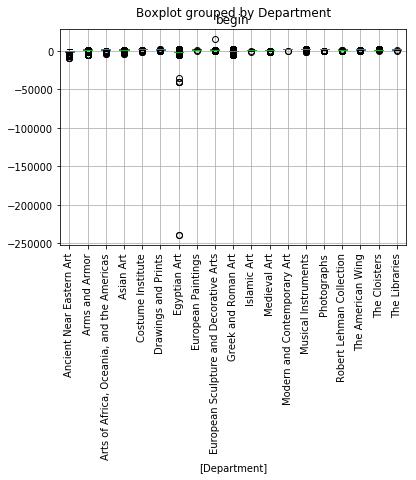

In [68]:
pd.options.display.max_rows = 400
dep = df['Department']
dep = pd.DataFrame(dep)
dep['begin'] = df['Object End Date']
dep.boxplot(by='Department')
plt.xticks(rotation=90)

- Of course, the most outlying years of origin are in the Egyptian Art Department. Let's take a look at them:

*Below are entries of the dataframe, which belong to the .999999 quantile of the wannabe normal distribution.*

In [79]:
s = df['Object End Date']
q = s.quantile(.999999)
df[['Department', 'Object Name', 'Title', 'Object Date', 'Object Begin Date', 'Object End Date']][(s.sort_values()[::-1] <= -q) | (s.sort_values()[::-1] >= q)]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Department  \
100098  European Sculpture and Decorative Arts   
363924                            Egyptian Art   
363926                            Egyptian Art   
363927                            Egyptian Art   
363928                            Egyptian Art   
363930                            Egyptian Art   
363938                            Egyptian Art   
365664                            Egyptian Art   

                                 Object Name  \
100098                                  Bowl   
363924          Tool, denticulate, Levallois   
363926                Tool, point, Levallois   
363927                       Core, Levallois   
363928                Tool, Levallois, Point   
363930         Tool, Biface, Hand-axe, Ovate   
363938  Tool, biface, hand ax, sub-cordiform   
365664                                  tool   

                                                    Title  \
100098  Wide-rimmed bowl with Vulcan Forging Arms with...   
363924                                  Denticulated Tool   
363926                          Retouched Levallois Point   
363927                                     Levallois Core   
363928                           Atypical Levallois Point   
363930          Biface, commonly referred to as a hand ax   
363938          Biface, commonly referred to as a hand ax   
365664                                               Tool   

                     Object Date  Object Begin Date  Object End Date  
100098               ca. 1528–30               1523            15335  
363924   ca. 240,000–40,000 B.C.            -240000           -40000  
363926   ca. 240,000–40,000 B.C.            -240000           -40000  
363927        ca. 240,000–40,000            -240000           -40000  
363928        ca. 240,000–40,000            -240000           -40000  
363930  ca. 400,000–240,000 B.C.            -400000          -240000  
363938  ca. 400,000–240,000 B.C.            -400000          -240000  
365664    ca. 90,000–35,000 B.C.             -95000           -35000

- We can see definitely a typo for the "Bowl" object in the 'Object End Date' feature.
- Then here are some of the oldest egyptian tools from the earliest human-race stages.

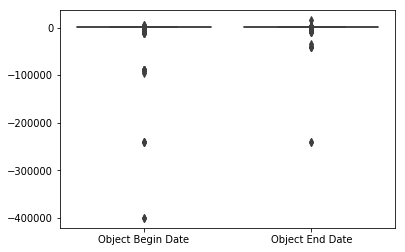

In [88]:
# plt.boxplot(df[['Object Begin Date', 'Object End Date']].head(10))
df[['Object Begin Date', 'Object End Date']].head(10)
import seaborn as sns
sns.boxplot(data=df[['Object Begin Date', 'Object End Date']])

To provide a better overview of the time intervals of our outliers, above we can see "boxplots" for both begin and end dates.

## Missing Data
**Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.**

Below is a list of how many percent of data in each feature is missing (not complete, not taking ing mind empty strings, etc.)

In [3]:
(df.isna().sum() * 100 / len(df)).sort_values()

Object Number               0.000000
Is Highlight                0.000000
Is Public Domain            0.000000
Object ID                   0.000000
Department                  0.000000
Link Resource               0.000000
Object End Date             0.000000
Object Begin Date           0.000000
Credit Line                 0.118042
Object Name                 0.379223
Medium                      1.517955
Object Date                 3.149273
Title                       6.416375
Classification             11.912662
Dimensions                 16.104107
Metadata Date              26.199774
Artist Display Name        42.932586
Artist Alpha Sort          42.940030
Artist Role                43.378168
Artist Begin Date          50.728031
Artist Display Bio         51.247841
Artist End Date            51.284636
Tags                       53.253916
Culture                    56.226870
Artist Nationality         61.175697
Artist Prefix              81.119463
Period                     81.157321
C

In [ ]:
df['Title'].replace(np.nan, '')
df['Object Name'].replace(np.nan, '')
df['Credit Line'].replace(np.nan, '')

Looks like I would be able to fill missing values in 'Classification' feature. 
- But first, I need to clean a bit the 'Medium' feature, to have an overview of the object I am trying to predict.

In [91]:
# https://gist.github.com/sebleier/554280
stop_words = [" ",
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [92]:
medium = df['Medium']
medium = medium.fillna('')
medium = medium.str.replace('\(.*\)|\\r\\n|\d|.*\)', '')
medium = medium.str.replace('\W', ' ')
medium = medium.str.lower()

def f(l):
    for sw in stop_words:
        if sw in l:
            l.remove(sw)
    return l
            
s = medium.str.split(' +')
s = s.apply(f)

What I did:

- filled missing with empty string (because of later string operations)
- replaced anything in brackets, '\r\n' endlines, all numbers and markers ('a)') with empty strings
- replaced all non-alpha-numeric characters with space.
- lowercase
- removed all stop-words
- split each entry into list of extracted words

In [93]:
f = [i for sub in s.tolist() for i in sub]
from collections import Counter
mc = Counter(f).most_common()[::-1]
to_remove = []
for k, v in mc:
    if v == 1:
        to_remove.append(k)
print(len(to_remove))
len(mc)

2808


6855


To reduce a bit the dimensionality (which would be really high - 6855dims), I decided to remove those words, which are not frequent (appearing only once in the whole column).
 
I used Counter to find the term frequency.

After reduction there are 6855-2808 = 4047 new columns for the dataset - as a 'Medium' feature.

In [94]:
def ff(l):
    for r in to_remove:
        if r in l:
            l.remove(r)
    return l
            
s = s.apply(ff)
s

0                                                    [gold]
1                                                    [gold]
2                                                    [gold]
3                                                    [gold]
4                                                    [gold]
5                                                    [gold]
6                                                    [gold]
7                                                    [gold]
8                                                    [gold]
9                                                    [gold]
10                                                   [gold]
11                                                   [gold]
12                                                   [gold]
13                                                   [gold]
14                                                 [silver]
15                                         [bronze, copper]
16                                      

I am using MultiLabelBinarizer to create a new dataframe of the only 'Medium' feature - but split by words.

In [95]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
med = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index, dtype='int8')
med = med.drop(columns=['', 'a'])
med.columns = ['m_' + str(col) for col in med.columns]

In [96]:
(medium == '').sum()

28324

In [97]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470172 entries, 0 to 470171
Columns: 4045 entries, m_abaca to m_ōban
dtypes: int8(4045)
memory usage: 1.8 GB


- Missing data are represented as zero vectors (did not need to inpute).

OK, looks fine. I know, the dimensionality of this feature is very high, but I have no idea, how else I would be able to "clean" the 'Medium' feature.

Anyways, there are lot of entries missing in this feature, but it is still less than in 'Classification' feature.

Here is used very similar analogy to the cleaning of 'Medium' feature.

In [101]:
clsf = df['Classification']
# pd.Series(clsf.unique()).to_csv('classification.csv')
clsf = clsf.str.replace('-|\(.*\)|\W|\d', ' ').str.lower()
pd.Series(clsf.unique()).to_csv('classification.csv')
clsf = clsf.str.replace('\s+', ' ').str.strip()

clsf = clsf.fillna('')
print("missing:", (clsf == '').sum())
print("nunique before: ", df['Classification'].nunique())
print("nunique after: ", clsf.nunique())
# clsf = clsf.str.split(' ')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


missing: 59325
nunique before:  1172
nunique after:  1154


In [109]:
# from sklearn.preprocessing import MinMaxScaler
# df_tmp = df[['Department', 'Object End Date', 'Object Begin Date']]
# df_tmp['Department'] = df_tmp['Department'].cat.codes.astype('int8')

# df_tmp[df_tmp.columns] = MinMaxScaler().fit_transform(df_tmp)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Now I will choose those features, which may be relevant for the prediction and have small amount onf missing values. Comes with the cleaned 'Medium' feature.

In [102]:
df_conv = pd.concat([df[['Is Highlight', 'Is Public Domain', 'Department', 'Object End Date', 'Object Begin Date']], 
          med], axis=1)
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470172 entries, 0 to 470171
Columns: 4050 entries, Is Highlight to m_ōban
dtypes: bool(2), category(1), int64(2), int8(4045)
memory usage: 1.8 GB


In [103]:
df_conv['Department'] = df_conv['Department'].astype('category').cat.codes.astype('int8')

In [104]:
y = clsf.copy()
y = y.replace(r'^\s*$', np.nan, regex=True)
y = y.astype('category')
cat_map = dict( zip( y.cat.codes, y ) )

y = y.cat.codes
y.isna().sum()
df_unknown = df_conv[y == -1]
y_unknown = y[y == -1]

df_known = df_conv[y != -1]
y_known = y[y != -1]

y_unknown.shape, y_known.shape

((59325,), (410847,))

(array([5.9489e+04, 1.0000e+00, 2.3000e+01, 2.0000e+00, 4.0000e+00,
        1.0000e+00, 2.1000e+01, 4.0000e+00, 1.0000e+00, 1.3000e+01,
        2.4000e+01, 1.0000e+00, 1.2000e+01, 1.1000e+01, 2.0000e+00,
        6.0000e+00, 2.0000e+00, 1.3000e+01, 2.7000e+01, 5.7000e+01,
        6.0000e+00, 3.0000e+00, 1.6900e+02, 5.0000e+00, 5.3000e+01,
        2.1700e+02, 5.0000e+01, 2.8000e+01, 1.7000e+01, 2.0000e+01,
        2.7000e+01, 8.3000e+01, 3.8600e+02, 1.7000e+01, 1.0000e+00,
        1.3000e+01, 5.0000e+01, 1.7300e+02, 4.8000e+01, 1.2200e+02,
        9.0000e+00, 4.7000e+01, 9.7000e+01, 5.2000e+01, 2.1000e+01,
        1.9600e+02, 3.3700e+02, 1.0000e+00, 2.0000e+00, 4.0000e+00,
        9.0000e+01, 2.5700e+02, 2.0000e+00, 1.0000e+00, 5.0000e+00,
        1.0300e+02, 1.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00,
        6.9000e+01, 2.0000e+00, 2.8000e+01, 1.0000e+00, 7.0000e+00,
        1.8500e+02, 1.0000e+00, 4.0000e+00, 1.0000e+00, 2.7100e+02,
        3.3000e+01, 2.0000e+02, 5.2500e+02, 5.90

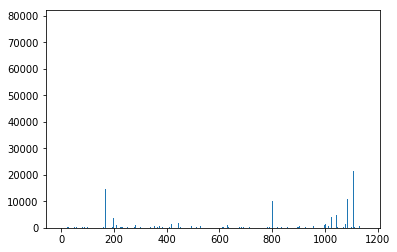

In [112]:
plt.hist(y, 1000)

### Missing Values Inputing (predicting) for 'Classification'
Now I want to use some predictive model to fill all missing values in 'Classification' feature. 
I dont have much time and resources for a proper prediction (CV & GridSearch, various metrics, ...) and other thing is, that I am trying to solve unordered multiclass classification problem.

In [16]:
from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_known, y_known, test_size=0.25, random_state=42)

In [145]:
# scl = MinMaxScaler()
# scl.fit(X_train)
# X_train = scl.transform(X_train)
# X_test = scl.transform(X_test)

In [148]:
# for k in [3, 5, 8]:
#     neigh = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     neigh.fit(X_train, y_train)
#     print(k, accuracy_score(neigh.predict(X_test), y_test))

# too long time.

KeyboardInterrupt: 

In [19]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

/Users/samuelfabo/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/samuelfabo/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/samuelfabo/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.7654607056624347


In [116]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1, verbose=5)
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   34.6s finished


0.19497234987148532


In [117]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.6880695537035595


In [118]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.8691000077887686


- Even scaling those non-medium features took a long time.
- KNN was running for too long, so I needed to kill it. 
- Logistic Regression was ran overnight - definitely a long time, so I am trying to use forests. Accuracy not bad.
- AdaBoost was killed after an hour
- RandomForest has very poor accuracy
- Naive Bayes has not bad accuracy
- Suprisingly - DecisionTree has nice accuracy (I KNOW, it may not be true and I should do GridSearch for best parameters and CV, sorry, I don't have much time).

In [119]:
y_pred = clf.predict(df_unknown)

In [120]:
y_u = y_unknown.copy()

j = 0
for i in y_u.index:
    y_u[i] = cat_map[y_pred[j]]
    j += 1
y_u

37959              textiles embroidered
65529      textiles painted and printed
65530                         hardstone
65531                          ceramics
65532                          ceramics
65533         textiles painted and dyed
65534                          ceramics
65535                         outerwear
65536                          ceramics
65537                        main dress
65538                          ceramics
65539                          ceramics
65540                    textiles woven
65541                    textiles woven
65542                             shell
65543                          ceramics
65544                          ceramics
65545                           lacquer
65546                        main dress
65547                           lacquer
65548                           lacquer
65549                           lacquer
65550                          ceramics
65551                           lacquer
65552                          textiles


In [121]:
filled_classification = pd.concat([y_known.apply(lambda x: cat_map[x]), y_u])
filled_classification.to_csv('predicted_classification.csv')

df['New Classification'] = filled_classification

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Now I inputed those missing classifications.

It does not seem to be so skewed from reality, take a look on this partial dataset:

In [122]:
df[['Object Name', 'Title', 'Medium', 'Classification', 'New Classification']][df['Classification'].isna()]

Object Name  \
65529                                           Stomacher   
65530                                        Shoe Buckles   
65531                                              Collar   
65532                                               Cuffs   
65533                                              Collar   
65534                                              Collar   
65535                                                Sash   
65536                                                Veil   
65537                                              Collar   
65538                                                Cape   
65539                                            Pelerine   
65540                                               Shawl   
65541                                               Fichu   
65542                                                Comb   
65543                                       Evening dress   
65544                                            Ensemble   
65545                                            Ensemble   
65546                                                Suit   
65547                                                Suit   
65548                                                Suit   
65549                                                Suit   
65550                                               Dress   
65551                                                Suit   
65552                                            Ensemble   
65553                                                Suit   
65554                                               Dress   
65555                                       Evening dress   
65556                                            Ensemble   
65557                                       Evening dress   
65558                                               Skirt   
65559                                             Maillot   
65560                                    Evening ensemble   
65561                                              Jacket   
65562                                              Bikini   
65563                                                 Hat   
65564                                                 Hat   
65565                                                Suit   
65566                                               Dress   
65567                                    Evening ensemble   
65568                                              Jacket   
65569                                    Evening ensemble   
65570                                            Ensemble   
65571                                    Evening ensemble   
65572                                    Evening ensemble   
65573                                               Dress   
65574                                           Beachwear   
65575                                                Suit   
65576                                                Suit   
65577                                       Evening dress   
65578                                       Evening dress   
65579                                       Evening dress   
65580                                       Evening dress   
65581                                    Evening ensemble   
65582                                       Evening dress   
65583                                             Sweater   
65584                                            Ensemble   
65585                                                Coat   
65586                                            Ensemble   
65587                                       Evening dress   
65588                                                Suit   
65589                                               Dress   
65590                                               Dress   
65591                                               Dress   
65592                                            Reticule   
65593                                               Purse   
65594               

# Conclusion

1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
2. **Check consistency (i.e. that same things are represented in the same way) of at least three features where you expect problems (include "Object Name" feature).**

Including 'Object Name' feature I checked (bad) consistency of 'Dynasty' and 'Country' feature.

3. **Select some features where you expect integrity problems (describe your choice) and check integrity of those features. By integrity we mean correct logical relations between features (e.g. female names for females only).**

I checked integrity on 'Classification' and 'Object Name' ; and then on time classification on 'Object Date', 'Period' and 'Reign'.

4. **Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.**

I converted:
- 'Department' to categorical
- 'Metadata Date' to timestamp
- 'Object {Begin, End} Date' to int
- 'Classification' to categorical
- 'Medium' to dummy variables (treating more as a text then a categorical)

5. **Find some outliers (describe your method).**

I found outliers by department and by begin and end date of an object. I used quantiles and boxplots to find them.

6. **Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.**

I detected missing values, features, with least missing values were inputed ('Title', 'Object Name', 'Credit Line') and represented as empty string.

Then i tried to inpute 'Classification' feature, with ~86% accuracy by DecisionTree.

* **Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.**

I tried to represent 'Medium' feature in machine-readable form (cleaning & creating dummy variables from separate words per entry). The dimensionality exploded to ~4000 features, but I was able to inpute missing values for 'Classification' feature.